<a href="https://colab.research.google.com/github/t0brig01/CSE696FinalProject/blob/main/MoralNeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import pandas as pd
from pandas import concat
from sklearn import preprocessing
import matplotlib.pyplot as plt
print ("TensorFlow version: " + tf.__version__)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score,cross_val_predict
from imblearn.over_sampling import SMOTE as smt
from sklearn.model_selection import train_test_split



TensorFlow version: 1.15.2


# Extra visual functions for data analysis


In [ ]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [ ]:
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()

In [ ]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

# **Data Loading/Manipulation**

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/t0brig01/CSE696FinalProject/main/TrolleyData.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230475 entries, 0 to 230474
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   _id             230475 non-null  object
 1   Scenario        230475 non-null  object
 2   UserID          230475 non-null  object
 3   Outcome         230475 non-null  int64 
 4   Session_id      230475 non-null  object
 5   Scenario_order  230475 non-null  int64 
 6   Template        230475 non-null  object
 7   answerLeft      230475 non-null  bool  
 8   lang            230475 non-null  object
 9   seenOther       230475 non-null  bool  
 10  country_code    229259 non-null  object
 11  country_full    229259 non-null  object
dtypes: bool(2), int64(2), object(8)
memory usage: 18.0+ MB


In [4]:
df.head()

,_id,Scenario,UserID,Outcome,Session_id,Scenario_order,Template,answerLeft,lang,seenOther,country_code,country_full
0,C3RGCjGPftjMKYHy2,Loop,0000dc12_9518522259818270,1,367585191-9.51852225982e+15,1,Desktop,False,de,True,DE,Germany
1,3F9SfDyofskDPna8R,Footbridge,0000dc12_9518522259818270,0,367585191-9.51852225982e+15,2,Desktop,False,de,True,DE,Germany
2,oz9anPbE6e52TKuJy,Switch,0000dc12_9518522259818270,1,367585191-9.51852225982e+15,3,Desktop,False,de,True,DE,Germany
3,dkAhBaLhzi62Pp6Hp,Footbridge,0002ae2d_2286850331484848,0,1654499857-2.28685033148e+15,1,Desktop,False,en,True,GB,United Kingdom
4,2ussgtw7vCZMNjxSJ,Switch,0002ae2d_2286850331484848,1,1654499857-2.28685033148e+15,2,Desktop,False,en,True,GB,United Kingdom


In [5]:
filtered = df.drop(['Session_id','Template','country_full','_id','answerLeft'], axis=1)
filtered.dropna()
filtered.replace('Loop',0,inplace=True)   #0 is loop trolley 
filtered.replace('Footbridge',1,inplace=True) #1 is footbridge trolley
filtered.replace('Switch',2,inplace=True) #2 is standard trolley

lang = dict()
country = dict()
iLang = 0
iCountry = 0
for index, x in filtered.iterrows():
  if x["lang"] not in lang.keys():
    lang[x["lang"]] = iLang
    iLang = iLang + 1
  if x["country_code"] not in country.keys():
    country[x["country_code"]] = iCountry
    iCountry = iCountry + 1
for key, value in country.items():
  filtered.replace(key,int(value),inplace=True)
for key, value in lang.items():
  filtered.replace(key,int(value),inplace=True)

In [6]:
filtered['country_code'] = filtered['country_code'].astype(int)

In [7]:
filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230475 entries, 0 to 230474
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Scenario        230475 non-null  int64 
 1   UserID          230475 non-null  object
 2   Outcome         230475 non-null  int64 
 3   Scenario_order  230475 non-null  int64 
 4   lang            230475 non-null  int64 
 5   seenOther       230475 non-null  bool  
 6   country_code    230475 non-null  int64 
dtypes: bool(1), int64(5), object(1)
memory usage: 10.8+ MB


In [8]:
filtered.describe()

,Scenario,Outcome,Scenario_order,lang,country_code
count,230475.000000,230475.000000,230475.000000,230475.000000,230475.000000
mean,0.997896,0.700453,1.955301,1.903946,15.234290
std,0.816945,0.458060,0.817113,1.716888,22.201642
min,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000,3.000000
50%,1.000000,1.000000,2.000000,1.000000,6.000000
75%,2.000000,1.000000,3.000000,3.000000,21.000000
max,2.000000,1.000000,3.000000,9.000000,169.000000


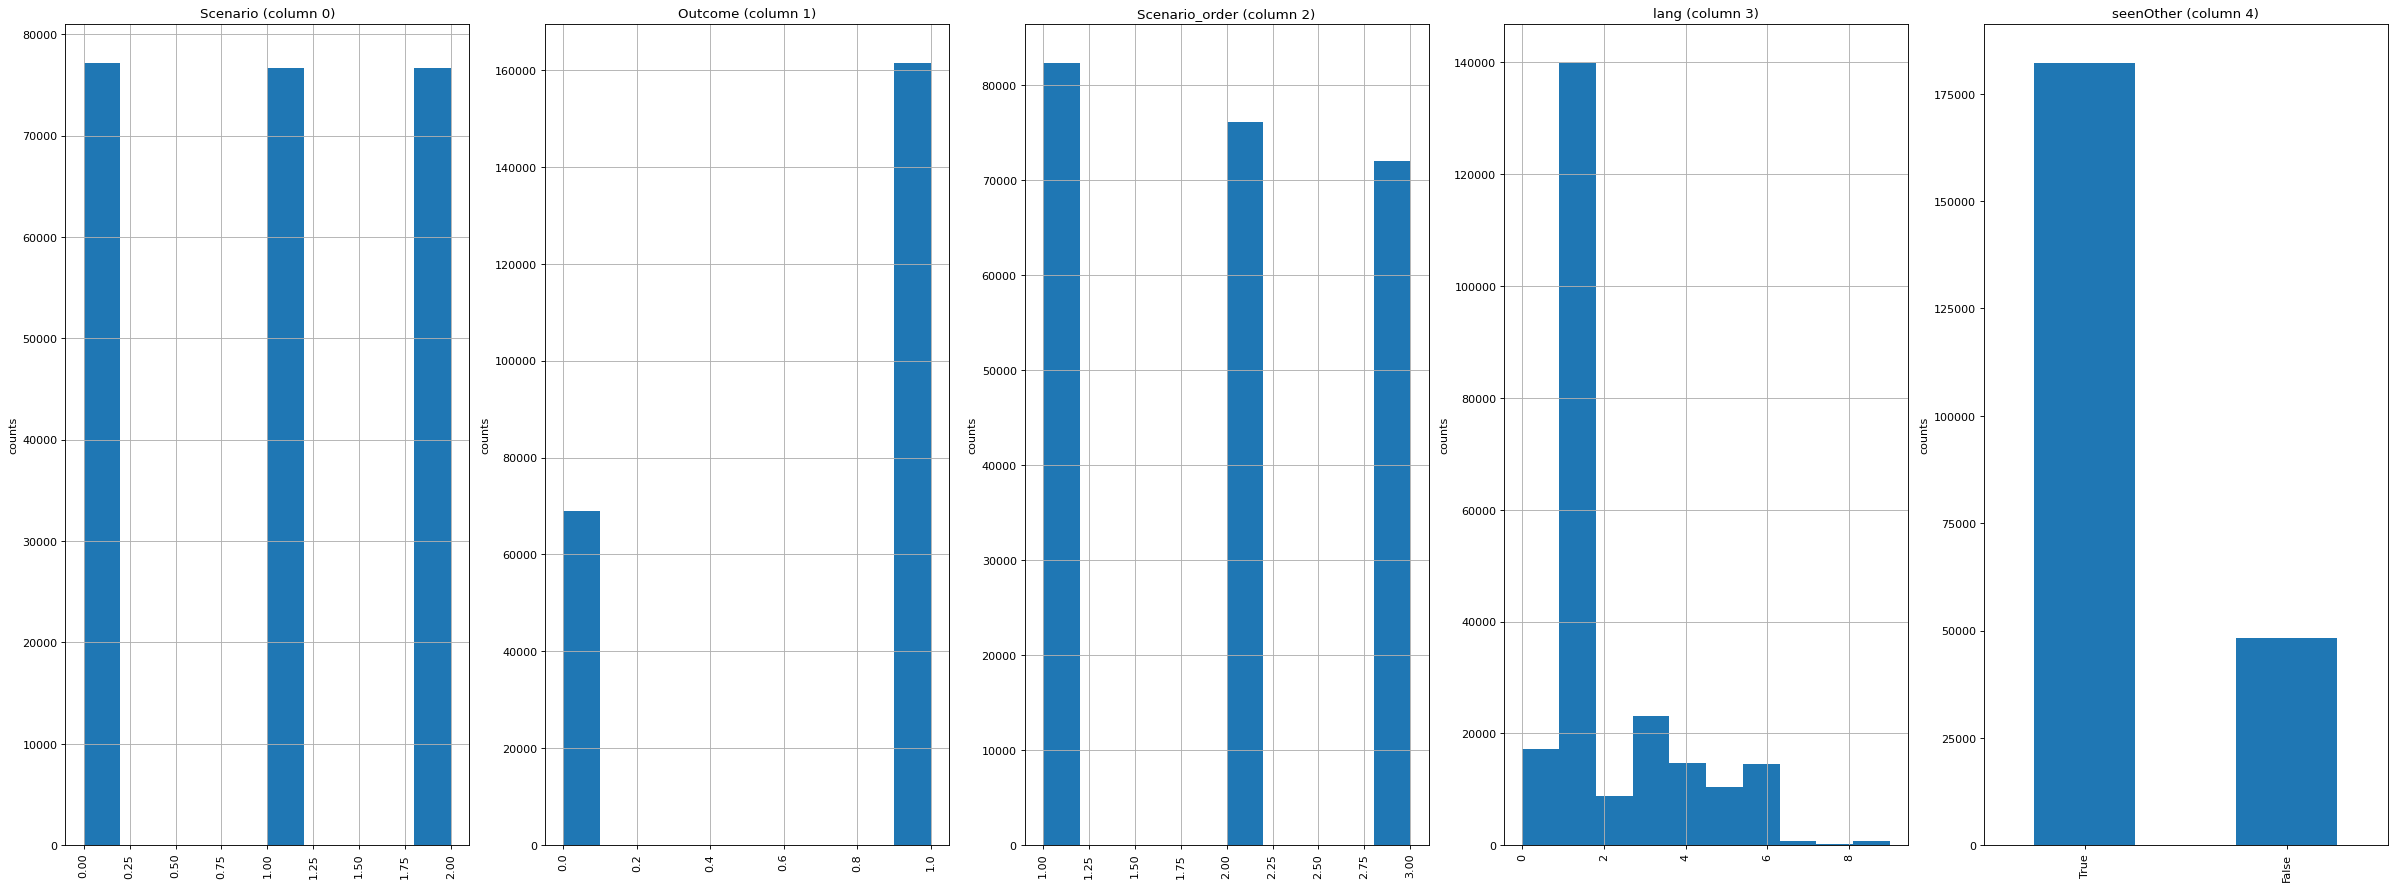

In [ ]:
plotPerColumnDistribution(filtered, 10, 10)

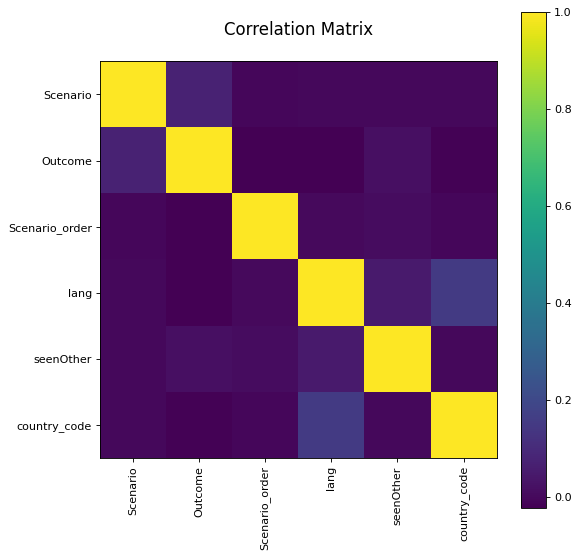

In [ ]:
plotCorrelationMatrix(filtered, 8)

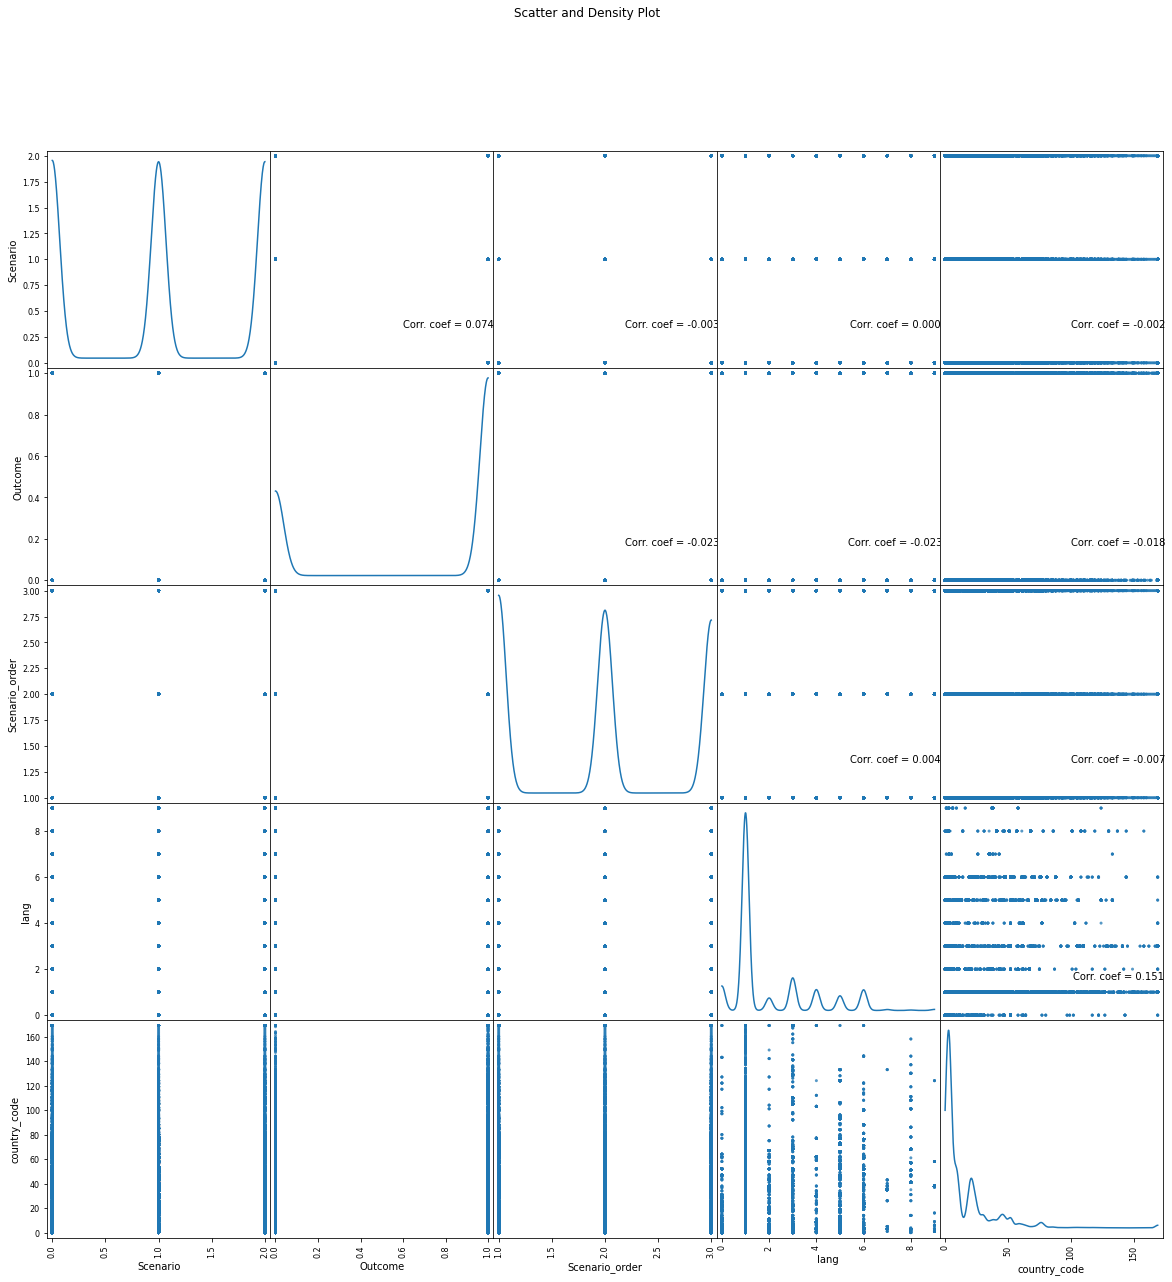

In [ ]:
plotScatterMatrix(filtered, 20, 10)

In [9]:
def create_dataset(X):
  
  Xs = X.drop(["UserID","Outcome"],axis = 1)
  Ys = X.drop(["Scenario","UserID","Scenario_order","lang","seenOther","country_code"],axis=1)
  Xs,Ys = Xs.astype(float),Ys.astype(float)
  encoder = LabelEncoder()
  encoder.fit(Ys)
  Ys = encoder.transform(Ys)
  return Xs,Ys

In [10]:
interval = int(len(filtered.index)/3)
filtered = filtered.sample(frac=1).reset_index(drop=True)

x_train, y_train = create_dataset(filtered.head(interval))
x_test, y_test = create_dataset(filtered.tail(interval))
x_val, y_val = create_dataset(filtered.loc[interval:interval*2])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76825 entries, 0 to 76824
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Scenario        76825 non-null  float64
 1   Scenario_order  76825 non-null  float64
 2   lang            76825 non-null  float64
 3   seenOther       76825 non-null  float64
 4   country_code    76825 non-null  float64
dtypes: float64(5)
memory usage: 2.9 MB


# **Neural Network**

In [12]:
from keras.models import Sequential
from keras import layers
from keras.layers import LSTM, Dense,Conv1D,MaxPooling1D,Flatten,Activation,BatchNormalization,Dropout
from keras.optimizers import RMSprop,SGD,Adam,Nadam
from tensorflow import keras
from keras import optimizers
import tensorflow as tf


In [14]:
#BEST
def create_model():
  model = Sequential()
  model.add(Dense(140,input_dim=5, activation='relu',kernel_initializer='random_uniform'))
  model.add(BatchNormalization())
  model.add(Dense(70, activation='relu',kernel_initializer='random_uniform'))
  model.add(BatchNormalization())
  model.add(Dense(1, activation='sigmoid',kernel_initializer='random_uniform'))
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=3000, verbose=1)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', model))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=2, shuffle=True)
results = cross_val_score(pipeline, x_train, y_train, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/100
38412/38412 [==============================] - 1s 15us/step - loss: 0.6693 - accuracy: 0.6095
Epoch 2/100
38412/38412 [==============================] - 0s 7us/step - loss: 0.6510 - accuracy: 0.6470
Epoch 3/100
38412/38412 [==============================] - 0s 7us/step - loss: 0.6412 - accuracy: 0.6565
Epoch 4/100
38412/38412 [==============================] - 0s 7us/step - loss: 0.6307 - accuracy: 0.6608
Epoch 5/100
38412/38412 [==============================] - 0s 7us/step - loss: 0.6191 - accuracy: 0.6642
Epoch 6/100
38412/38412 [==============================] - 0s 7us/step - loss: 0.6068 - accuracy: 0.6726
Epoch 7/100
38412/38412 [==============================] - 0s 7us/step - loss: 0.5969 - accuracy: 0.6824
Epoch 8/100
38412/38412 [==============================] - 0s 7us/step - loss: 0.5872 - accuracy: 0.6963
Epoch 9/100
38412/38412 [==============================] - 0s 7us/step - loss: 0.5807 - accuracy: 0.7005
Epoch 10/100
38412/38412 [============================

# Prediction Testing

In [63]:
x = pd.DataFrame({'Scenario': [2,2,2],'Scenario_order' : [0,0,0],'lang': [1,3,5], 'seenOther': [0,0,0],'country_code': [3,3,3]})

# 'Scenario' = 2 #0 is loop trolley, 1 is footbridge trolley, 2 is standard trolley
# 'Scenario_order' = 0 #First one if given multiple
# 'lang' = 1 #English - See cell below for language codes
# 'seenOther' = 0 #Has not seen other's answers
# 'country_code' = 3 #US - See cell below for country codes 

prediction=pipeline['mlp'].predict(x)
prediction 

3/3 [==============================] - 0s 400us/step


array([[1],
       [1],
       [1]])

In [15]:
lang

{'ar': 8,
 'de': 0,
 'en': 1,
 'es': 5,
 'fr': 3,
 'ja': 9,
 'kr': 7,
 'pt': 4,
 'ru': 6,
 'zh': 2}

In [18]:
country

{'-': 62,
 'AD': 133,
 'AE': 78,
 'AF': 139,
 'AL': 126,
 'AM': 81,
 'AO': 103,
 'AQ': 163,
 'AR': 77,
 'AT': 25,
 'AU': 19,
 'AX': 168,
 'AZ': 69,
 'BA': 102,
 'BB': 153,
 'BD': 82,
 'BE': 22,
 'BG': 54,
 'BH': 94,
 'BJ': 131,
 'BN': 149,
 'BO': 56,
 'BR': 9,
 'BS': 83,
 'BY': 39,
 'CA': 6,
 'CD': 135,
 'CH': 18,
 'CI': 155,
 'CL': 17,
 'CN': 20,
 'CO': 32,
 'CR': 59,
 'CU': 89,
 'CV': 164,
 'CY': 122,
 'CZ': 26,
 'DE': 0,
 'DK': 31,
 'DM': 165,
 'DO': 93,
 'DZ': 68,
 'EC': 66,
 'EE': 8,
 'EG': 57,
 'ES': 11,
 'FI': 29,
 'FO': 154,
 'FR': 4,
 'GB': 1,
 'GD': 125,
 'GE': 100,
 'GF': 141,
 'GG': 150,
 'GH': 151,
 'GI': 160,
 'GP': 97,
 'GR': 44,
 'GT': 13,
 'GY': 166,
 'HK': 43,
 'HN': 96,
 'HR': 85,
 'HT': 98,
 'HU': 14,
 'ID': 50,
 'IE': 34,
 'IL': 61,
 'IM': 115,
 'IN': 46,
 'IQ': 101,
 'IR': 65,
 'IS': 27,
 'IT': 7,
 'JE': 138,
 'JM': 118,
 'JO': 108,
 'JP': 38,
 'KE': 91,
 'KG': 55,
 'KH': 113,
 'KN': 147,
 'KR': 35,
 'KW': 111,
 'KY': 140,
 'KZ': 76,
 'LB': 119,
 'LC': 152,
 'LI':

# Other less accurate NNs

In [ ]:
#Basic
model = Sequential()
model.add(Dense(60, input_dim=5, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train,y_train,epochs=10, validation_data=(x_val,y_val),batch_size=50)
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print("Results: %.2f%% (%.2f%%)" % (acc*100, loss*100))

Train on 76825 samples, validate on 76826 samples
Epoch 1/10
76825/76825 [==============================] - 5s 68us/step - loss: 0.6000 - accuracy: 0.6998 - val_loss: 0.5840 - val_accuracy: 0.7008
Epoch 2/10
76825/76825 [==============================] - 5s 59us/step - loss: 0.5817 - accuracy: 0.7001 - val_loss: 0.5781 - val_accuracy: 0.7012
Epoch 3/10
76825/76825 [==============================] - 4s 58us/step - loss: 0.5793 - accuracy: 0.7015 - val_loss: 0.5777 - val_accuracy: 0.7033
Epoch 4/10
76825/76825 [==============================] - 5s 59us/step - loss: 0.5785 - accuracy: 0.7013 - val_loss: 0.5767 - val_accuracy: 0.7013
Epoch 5/10
76825/76825 [==============================] - 5s 59us/step - loss: 0.5781 - accuracy: 0.7011 - val_loss: 0.5768 - val_accuracy: 0.7027
Epoch 6/10
76825/76825 [==============================] - 5s 66us/step - loss: 0.5778 - accuracy: 0.7012 - val_loss: 0.5770 - val_accuracy: 0.7036
Epoch 7/10
76825/76825 [==============================] - 5s 70us/st

KeyboardInterrupt: ignored

In [ ]:
model = Sequential()

model.add(Dense(24, input_dim=5,kernel_initializer='random_uniform'))

model.add(layers.Dense(64,activation="relu",kernel_initializer='random_uniform'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(.5))
model.add(layers.Dense(64, activation="relu",kernel_initializer='random_uniform'))
model.add(layers.BatchNormalization())

model.add(Dense(1,activation="sigmoid",kernel_initializer='random_uniform'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# fit the keras model on the dataset
model.fit(x_train, y_train, epochs=10)
# evaluate the keras model
_, accuracy = model.evaluate(x_test, y_test)
print('Accuracy: %.2f%%' % (accuracy*100))

Epoch 1/10
76825/76825 [==============================] - 5s 64us/step - loss: 0.5951 - accuracy: 0.6942
Epoch 2/10
76825/76825 [==============================] - 5s 60us/step - loss: 0.5838 - accuracy: 0.7003
Epoch 3/10
76825/76825 [==============================] - 5s 60us/step - loss: 0.5828 - accuracy: 0.7012
Epoch 4/10
76825/76825 [==============================] - 5s 61us/step - loss: 0.5817 - accuracy: 0.7016
Epoch 5/10
76825/76825 [==============================] - 5s 60us/step - loss: 0.5816 - accuracy: 0.7006
Epoch 6/10
76825/76825 [==============================] - 5s 60us/step - loss: 0.5811 - accuracy: 0.7011
Epoch 7/10
76825/76825 [==============================] - 5s 60us/step - loss: 0.5813 - accuracy: 0.7003
Epoch 8/10
76825/76825 [==============================] - 5s 61us/step - loss: 0.5808 - accuracy: 0.7006
Epoch 9/10
76825/76825 [==============================] - 5s 61us/step - loss: 0.5813 - accuracy: 0.6998
Epoch 10/10
76825/76825 [==============================

In [ ]:
def create_model():
  my_init = keras.initializers.glorot_uniform(seed=1)
  model = Sequential()
  model.add(Dense(140,input_dim=5, activation='relu',kernel_initializer=my_init))
  model.add(BatchNormalization())
  model.add(Dense(70, activation='relu',kernel_initializer=my_init))
  model.add(BatchNormalization())
  model.add(Dense(1, activation='sigmoid',kernel_initializer=my_init))
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  return model

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=100, batch_size=1000, verbose=1)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=2, shuffle=True)
results = cross_val_score(pipeline, x_train, y_train, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/100
38412/38412 [==============================] - 3s 66us/step - loss: 0.6454 - accuracy: 0.6385
Epoch 2/100
38412/38412 [==============================] - 1s 15us/step - loss: 0.5918 - accuracy: 0.6901
Epoch 3/100
38412/38412 [==============================] - 1s 14us/step - loss: 0.5818 - accuracy: 0.6985
Epoch 4/100
38412/38412 [==============================] - 1s 15us/step - loss: 0.5795 - accuracy: 0.7009
Epoch 5/100
38412/38412 [==============================] - 1s 15us/step - loss: 0.5796 - accuracy: 0.7022
Epoch 6/100
38412/38412 [==============================] - 1s 15us/step - loss: 0.5782 - accuracy: 0.7035
Epoch 7/100
38412/38412 [==============================] - 1s 15us/step - loss: 0.5772 - accuracy: 0.7046
Epoch 8/100
38412/38412 [==============================] - 1s 14us/step - loss: 0.5769 - accuracy: 0.7052
Epoch 9/100
38412/38412 [==============================] - 1s 15us/step - loss: 0.5773 - accuracy: 0.7039
Epoch 10/100
38412/38412 [====================

# Epochs vs Batch Experiment

In [ ]:
def buildModel():
  model = Sequential()
  model.add(Dense(60, input_dim=5, activation='relu'))
  model.add(Dense(40, activation='relu'))
  model.add(Dense(10, activation='sigmoid'))
  model.add(Dense(1, activation='sigmoid'))
  return model

In [ ]:
acc = dict()
for batch in range(1,15): #batch size 
  for epoch in range(1,15): #epochs
    print("Epochs: {0} \t Batch Size: {1}".format(10*epoch,16*batch))
    model = buildModel()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=(10*epoch), batch_size=(16*batch),verbose=0)
    loss, accuracy = model.evaluate(x_test, y_test,verbose=0)
    key = "epochs{0}batch{1}".format(10*epoch,16*batch)
    acc[key] = accuracy*100
    print('Accuracy: %.2f%%' % (accuracy*100))

Epochs: 10 	 Batch Size: 16
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Accuracy: 70.39%
Epochs: 20 	 Batch Size: 16
Accuracy: 70.27%
Epochs: 30 	 Batch Size: 16
Accuracy: 70.59%
Epochs: 40 	 Batch Size: 16
Accuracy: 70.60%
Epochs: 50 	 Batch Size: 16
Accuracy: 70.44%
Epochs: 60 	 Batch Size: 16
Accuracy: 70.70%
Epochs: 70 	 Batch Size: 16
Accuracy: 70.38%
Epochs: 80 	 Batch Size: 16
Accuracy: 70.79%
Epochs: 90 	 Batch Size: 16
Accuracy: 70.85%
Epochs: 100 	 Batch Size: 16
Accuracy: 70.80%
Epochs: 110 	 Batch Size: 16
Accuracy: 70.66%
Epochs: 120 	 Batch Size: 16
Accuracy: 70.85%
Epochs: 130 	 Batch Size: 16
Accuracy: 70.72%
Epochs: 140 	 Batch Size: 16
Accuracy: 70.70%
Epochs: 10 	 Batch Size: 32
Accuracy: 70.41%
Epochs: 20 	 Batch Size: 32
Accuracy: 70.28%
Epochs: 30 	 Batch Size: 32
Accuracy: 70.56%
Epochs: 40 	 Batch Size: 32
Accuracy: 70.51%
Epochs: 5

# Hyperparameters


In [ ]:
!pip install git+https://github.com/keras-team/keras-tuner
# !pip uninstall tensorflow -y
!pip install tensorflow-gpu
!pip install gdown

  Cloning https://github.com/keras-team/keras-tuner to /tmp/pip-req-build-dbblphoy
  Running command git clone -q https://github.com/keras-team/keras-tuner /tmp/pip-req-build-dbblphoy
  Created wheel for keras-tuner: filename=keras_tuner-1.0.3-cp37-none-any.whl size=93604 sha256=91d27f0aa114968deee6dce7e40b81365f98a8d465db62472f57a3bc743cbab0
  Stored in directory: /tmp/pip-ephem-wheel-cache-s55ow8p_/wheels/6c/55/2d/6e178386cb7a2d7da5a7059752a2b58791705c9c8718c5f07a
Successfully built keras-tuner
     |████████████████████████████████| 394.3MB 31kB/s 


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pprint import pprint
from kerastuner.tuners import RandomSearch, BayesianOptimization

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
def tune_optimizer_model(hp):
    model = keras.Sequential()

    model.add(keras.layers.Dense(24, input_dim=5,kernel_initializer='random_uniform'))

    model.add(keras.layers.Dense(64,activation="relu",kernel_initializer='random_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    model.add(keras.layers.Dense(64, activation="relu",kernel_initializer='random_uniform'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(1,activation="sigmoid",kernel_initializer='random_uniform'))
    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    model.compile(
        optimizer=optimizer,
        loss = 'binary_crossentropy',
        metrics = ['accuracy'])
    return model

In [ ]:
from kerastuner.tuners import RandomSearch
MAX_TRIALS = 20
EXECUTIONS_PER_TRIAL = 5

tuner = RandomSearch(
    tune_optimizer_model,
    objective='val_accuracy',
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTIONS_PER_TRIAL,
    directory='test_dir',
    project_name='tune_optimizer',
    seed=RANDOM_SEED
)
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project test_dir/tune_optimizer/oracle.json
Search space summary
Default search space size: 1
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd', 'rmsprop'], 'ordered': False}


In [ ]:
TRAIN_EPOCHS = 20

tuner.search(x=x_train,
             y=y_train,
             epochs=TRAIN_EPOCHS,
             validation_data=(x_test, y_test))

Trial 3 Complete [00h 09m 51s]
val_accuracy: 0.7029742956161499

Best val_accuracy So Far: 0.7031591296195984
Total elapsed time: 00h 31m 44s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in test_dir/tune_optimizer
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
optimizer: rmsprop
Score: 0.7031591296195984
Trial summary
Hyperparameters:
optimizer: adam
Score: 0.7030419826507568
Trial summary
Hyperparameters:
optimizer: sgd
Score: 0.7029742956161499


In [ ]:
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'optimizer': 'rmsprop'}

In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1600      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6